## Imports

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
import torch.nn as nn
import time
import random
import copy
from matplotlib import pyplot as plt

## Hyperparameters and other constants

In [2]:
GAMMA = 0.99
MEMORY_SIZE = 1000000
ACTOR_LEARNING_RATE = 0.001
CRITIC_LEARNING_RATE = 0.001
ACTOR_LAYER_SIZES = [128, 128, 64, 32, 16]
CRITIC_LAYER_SIZES = [128, 256]
BATCH_SIZE = 64
NUMBER_OF_EPISODES = 600
TAU = 0.00025
GOAL_SCORE = 30
ENV_PATH = 'Reacher_Windows_x86_64/Reacher.exe'
ACTOR_PATH = 'actor.pth'
CRITIC_PATH = 'critic.pth'

## Auxiliar functions

Auxiliar functions used in the main program

In [3]:
# If GPU is available, use it for trainining the agent's DQN
def get_default_device():
    if torch.cuda.is_available():
        print('CUDA is available. Training on GPU.')
        return torch.device('cuda')
    else:
        print('CUDA is not available. Training on CPU.')
        return torch.device('cpu')

# Create Unity environment
def create_environment(train_mode, path_to_env):
    env = UnityEnvironment(file_name=path_to_env)
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]
    env_info = env.reset(train_mode=train_mode)[brain_name]
    state_size = len(env_info.vector_observations[0])
    action_size = brain.vector_action_space_size
    return env, env_info, brain_name, state_size, action_size

## Class ReplayMemory

Memory of transitions for experience replay.

In [4]:
class ReplayMemory:

    # Create replay memory
    def __init__(self, state_size, action_size):
        self.states = np.zeros((MEMORY_SIZE, state_size))
        self.states_next = np.zeros((MEMORY_SIZE, state_size))
        self.actions = np.zeros((MEMORY_SIZE, action_size))
        self.rewards = np.zeros(MEMORY_SIZE)
        self.terminal_states = np.zeros(MEMORY_SIZE)
        self.current_size = 0

    # Store a transition (s,a,r,s') in the replay memory
    def store_transition(self, state, action, reward, state_next, terminal_state):
        i = self.current_size
        self.states[i] = state
        self.states_next[i] = state_next
        self.actions[i] = action
        self.rewards[i] = reward
        self.terminal_states[i] = terminal_state
        self.current_size = i + 1

        if self.current_size >= MEMORY_SIZE - 1:
            self.current_size = 0

    # Generate a random sample of transitions from the replay memory
    def sample_memory(self, batch_size):
        batch = np.random.choice(self.current_size, batch_size)
        states = torch.from_numpy(self.states[batch]).float().to(device)
        states_next = torch.from_numpy(self.states_next[batch]).float().to(device)
        rewards = torch.from_numpy(self.rewards[batch]).float().to(device)
        actions = torch.from_numpy(self.actions[batch]).float().to(device)
        terminal_states = torch.from_numpy(self.terminal_states[batch].astype(np.uint8)).float().to(device)
        return states, actions, rewards, states_next, terminal_states

## Class OUNoise

Ornstein-uhlenbeck noise to add some exploration to the agent.

In [5]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.size = size  # num agents added
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.state = None
        random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        # dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

## Classes Actor & Critic

Actor and critic models

In [6]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):

    # Create neural network
    def __init__(self, state_size, action_size, layer_sizes):
        super(Actor, self).__init__()
        self.layer_1 = nn.Linear(state_size, layer_sizes[0])
        self.batch_norm_1 = nn.BatchNorm1d(layer_sizes[0])
        self.layer_2 = nn.Linear(layer_sizes[0], layer_sizes[1])
        self.batch_norm_2 = nn.BatchNorm1d(layer_sizes[1])
        self.layer_3 = nn.Linear(layer_sizes[1], layer_sizes[2])
        self.batch_norm_3 = nn.BatchNorm1d(layer_sizes[2])
        self.layer_4 = nn.Linear(layer_sizes[2], layer_sizes[3])
        self.batch_norm_4 = nn.BatchNorm1d(layer_sizes[3])
        self.layer_5 = nn.Linear(layer_sizes[3], layer_sizes[4])
        self.batch_norm_5 = nn.BatchNorm1d(layer_sizes[4])
        self.layer_6 = nn.Linear(layer_sizes[4], action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.layer_1.weight.data.uniform_(*hidden_init(self.layer_1))
        self.layer_2.weight.data.uniform_(*hidden_init(self.layer_2))
        self.layer_3.weight.data.uniform_(*hidden_init(self.layer_3))
        self.layer_4.weight.data.uniform_(*hidden_init(self.layer_4))
        self.layer_5.weight.data.uniform_(*hidden_init(self.layer_5))
        self.layer_6.weight.data.uniform_(-3e-3, 3e-3)

    # Forward pass
    def forward(self, state):
        x = torch.nn.functional.relu(self.batch_norm_1(self.layer_1(state)))
        x = torch.nn.functional.relu(self.batch_norm_2(self.layer_2(x)))
        x = torch.nn.functional.relu(self.batch_norm_3(self.layer_3(x)))
        x = torch.nn.functional.relu(self.batch_norm_4(self.layer_4(x)))
        x = torch.nn.functional.relu(self.batch_norm_5(self.layer_5(x)))
        x = torch.tanh(self.layer_6(x))

        return x

class Critic(nn.Module):

    # Create neural network
    def __init__(self, state_size, action_size, layer_sizes):
        super(Critic, self).__init__()
        self.layer_1 = nn.Linear(state_size, layer_sizes[0])
        self.batch_norm_1 = nn.BatchNorm1d(layer_sizes[0])
        self.layer_2 = nn.Linear(layer_sizes[0]+action_size, layer_sizes[1])
        self.batch_norm_2 = nn.BatchNorm1d(layer_sizes[1])
        self.layer_3 = nn.Linear(layer_sizes[1], 1)
        self.reset_parameters()

    # Weight initialization
    def reset_parameters(self):
        self.layer_1.weight.data.uniform_(*hidden_init(self.layer_1))
        self.layer_2.weight.data.uniform_(*hidden_init(self.layer_2))
        self.layer_3.weight.data.uniform_(-3e-3, 3e-3)

    # Forward pass
    def forward(self, state, action):
        x_s = torch.nn.functional.relu(self.batch_norm_1(self.layer_1(state)))
        x = torch.cat((x_s, action), dim=1)
        x = torch.nn.functional.relu(self.batch_norm_2(self.layer_2(x)))
        x = self.layer_3(x)

        return x

## Class Agent

DDPG agent with actor and critic networks, as well as their respective target networks.


In [7]:
class Agent:

    # Create DDPG agent
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.scores = []
        self.memory = ReplayMemory(state_size, action_size)
        self.noise = OUNoise((1, action_size), 0)
        self.actor_local = Actor(state_size, action_size, ACTOR_LAYER_SIZES).to(device)
        self.actor_target = Actor(state_size, action_size, ACTOR_LAYER_SIZES).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor_local.parameters(), lr=ACTOR_LEARNING_RATE)
        self.soft_update(self.actor_local, self.actor_target, 0)
        self.critic_local = Critic(state_size, action_size, CRITIC_LAYER_SIZES).to(device)
        self.critic_target = Critic(state_size, action_size, CRITIC_LAYER_SIZES).to(device)
        self.critic_optimizer = torch.optim.Adam(self.critic_local.parameters(), lr=CRITIC_LEARNING_RATE)
        self.soft_update(self.critic_local, self.critic_target, 0)

    # Store a tuple (s, a, r, s') for experience replay
    def remember(self, state, action, reward, next_state, terminal_state):
        self.memory.store_transition(state, action, reward, next_state, terminal_state)

    # Select action following the current policy
    def act(self, state, add_noise=True):
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(torch.from_numpy(state).float().to(device)).cpu().data.numpy()
        self.actor_local.train()

        if add_noise:
            action += self.noise.sample()

        return np.clip(action, -1, 1)

    # Perform an action over the environment
    def step(self, action, brain_name, env):
        env_info = env.step(action)[brain_name]
        reward = env_info.rewards[0]
        next_state = env_info.vector_observations
        terminal_state = env_info.local_done[0]
        return reward, next_state, terminal_state

    # Update policy and value function.
    def learn(self):
        if self.memory.current_size < BATCH_SIZE: return

        # Sample a batch of experiences from memory
        states, actions, rewards, next_states, terminal_states = self.memory.sample_memory(BATCH_SIZE)

        # ------------------ CRITIC TRAINING ------------------
        # Predict next actions and their Q values using target networks
        actions_next = self.actor_target(next_states)
        q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current state
        q_targets = rewards.unsqueeze(1) + (GAMMA * q_targets_next * (1 - terminal_states).unsqueeze(1))
        # Compute actual q value for current states and actions
        q_expected = self.critic_local(states, actions)
        # Compute critic loss and minimize it
        critic_loss = nn.functional.mse_loss(q_expected, q_targets)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ------------------ ACTOR TRAINING ------------------
        # Compute actor loss
        actions_predicted = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_predicted).mean()
        # Minimize it
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ------------------ SOFT UPDATING ------------------
        self.soft_update(self.actor_local, self.actor_target, TAU)
        self.soft_update(self.critic_local, self.critic_target, TAU)

    # Soft update a target network
    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    # Add the obtained score in a list to be presented later
    def add_score(self, score):
        self.scores.append(score)

    # Display the obtained scores graphically
    def display_scores_graphically(self):
        plt.plot(self.scores)
        plt.xlabel("Episode")
        plt.ylabel("Score")


## Main program

CUDA is not available. Training on CPU.


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Episode   1:   average score 1.529999965801835   transitions: 1001)  score:  1.529999965801835 
Episode   2:   average score 1.1449999744072556   transitions: 2002)  score:  0.7599999830126762 
Episode   3:   average score 1.0666666428248088   transitions: 3003)  score:  0.909999979659915 
Episode   4:   average score 1.0974999754689634   transitions: 4004)  score:  1.1899999734014273 
Episode   5:   average score 1.0479999765753747   transitions: 5005)  score:  0.8499999810010195 
Episode   6:   average score 0.9183333128069838   transitions: 6006)  score:  0.2699999939650297 
Episode   7:   average score 1.1742856880383832   transitions: 7007)  score:  2.7099999394267797 
Episode   8:   average score 1.1062499752733856   transitions: 8008)  score:  0.6299999859184027 
Episode   9:   average score 1.1088888641032908   transitions: 9009)  score:  1.1299999747425318 
Episode  10:   average score 1.188999973423779   transitions: 10010)  score:  1.9099999573081732 
Episode  11:   average 

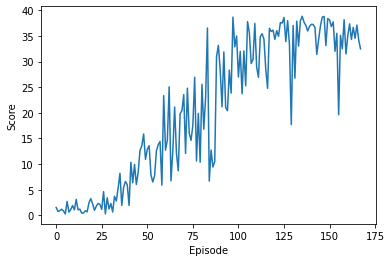

In [8]:
# Checking if GPU is available
device = get_default_device()

env, env_info, brain_name, state_size, action_size = create_environment(True, ENV_PATH)
agent = Agent(state_size, action_size)
scores = []
goal_reached = False
episode = 0
total_steps = 1
start_time = time.perf_counter()

while (episode < NUMBER_OF_EPISODES) and not goal_reached:
    episode += 1
    step = 1
    env_info = env.reset(train_mode=True)[brain_name]
    state = env_info.vector_observations
    agent.noise.reset()
    end_episode = False
    reward_accumulated = 0
    while not end_episode:
        # Perform an action for the current state, execute the action, retrieve env info, store transition into memory and learn from passed experiences
        action = agent.act(state)
        reward, next_state, terminal_state = agent.step(action, brain_name, env)
        agent.remember(state, action, reward, next_state, terminal_state)
        agent.learn()

        # Detect end of episode
        if terminal_state:
            reward_accumulated += reward
            agent.add_score(reward_accumulated)
            scores.append(reward_accumulated)
            if episode < 100:
                avg_score = sum(scores) / len(scores)
            else:
                avg_score = sum(scores[-100:]) / 100
            if avg_score >= GOAL_SCORE:
                goal_reached = True
            print("Episode {0:>3}: ".format(episode),
                  " average score {0:>3} ".format(avg_score),
                  " transitions: " + str(agent.memory.current_size) + ")",
                  " score: ", reward_accumulated, '\r')
            end_episode = True
        else:
            state = next_state
            step += 1
            total_steps += 1
            reward_accumulated += reward

env.close()

# Printing some info
if goal_reached:
    print("Reached goal sucessfully.")
    torch.save(agent.actor_local.state_dict(), ACTOR_PATH)
    torch.save(agent.critic_local.state_dict(), CRITIC_PATH)

else:
    print("Failure to reach the goal.")

print("Time:", round((time.perf_counter() - start_time) / 60), "minutes")

agent.display_scores_graphically()
